In [1]:
# IMPORT PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

from datetime import datetime

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# import the dataset
import requests

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
dataset_ids = ["daily-shelter-overnight-service-occupancy-capacity", "central-intake-calls"]

for d_id in dataset_ids:
    url = base_url + "/api/3/action/package_show"
    params = { "id": d_id }
    package = requests.get(url, params = params).json()
    
    for idx, resource in enumerate(package["result"]["resources"]):
        if resource["datastore_active"]:
           # Get all records in CSV format:
           url = base_url + "/datastore/dump/" + resource["id"]
           resource_dump_data = requests.get(url).text
           # Save CSV files
           filename = resource['name'].lower().replace(' ', '_')
           f = open(filename + '.csv', "w")
           f.write(resource_dump_data)
           f.close()

In [3]:
# import datasets 
shelter_use2023 = pd.read_csv("daily_shelter_overnight_occupancy.csv")
shelter_use2022 = pd.read_csv("daily-shelter-overnight-service-occupancy-capacity-2022.csv")
shelter_use2021 = pd.read_csv("daily-shelter-overnight-service-occupancy-capacity-2021.csv")

print(shelter_use2021.head(10))

   _id OCCUPANCY_DATE  ORGANIZATION_ID  \
0    1       21-01-01               24   
1    2       21-01-01               24   
2    3       21-01-01               24   
3    4       21-01-01               24   
4    5       21-01-01               24   
5    6       21-01-01               24   
6    7       21-01-01               24   
7    8       21-01-01               24   
8    9       21-01-01               14   
9   10       21-01-01               14   

                         ORGANIZATION_NAME  SHELTER_ID  \
0                 COSTI Immigrant Services          40   
1                 COSTI Immigrant Services          40   
2                 COSTI Immigrant Services          40   
3                 COSTI Immigrant Services          40   
4                 COSTI Immigrant Services          40   
5                 COSTI Immigrant Services          40   
6                 COSTI Immigrant Services          40   
7                 COSTI Immigrant Services          40   
8  Christie Oss

DATA EXPLORATION + CLEANING

In [4]:
# match date formats to YYYY-MM-DD
shelter_use2021["OCCUPANCY_DATE"] = pd.to_datetime(shelter_use2021["OCCUPANCY_DATE"], format='%y-%m-%d')
shelter_use2021["OCCUPANCY_DATE"] = shelter_use2021["OCCUPANCY_DATE"].dt.strftime('%Y-%m-%d')

shelter_use2022["OCCUPANCY_DATE"] = pd.to_datetime(shelter_use2022["OCCUPANCY_DATE"], format='%y-%m-%d')
shelter_use2022["OCCUPANCY_DATE"] = shelter_use2022["OCCUPANCY_DATE"].dt.strftime('%Y-%m-%d')

In [5]:
# create a combined object
shelter_use_combined = pd.concat([shelter_use2023, shelter_use2022, shelter_use2021], ignore_index=True)

# drop unnecesary columns + data points
toronto = shelter_use_combined[shelter_use_combined['LOCATION_CITY'] == 'Toronto']

toronto_shelter_usage = shelter_use_combined[["_id", "OCCUPANCY_DATE", "SHELTER_ID", "LOCATION_ID", "PROGRAM_ID", "OCCUPANCY_RATE_BEDS", "OCCUPANCY_RATE_ROOMS"]]

# toronto_shelter_usage['OCCUPANCY_RATE_BEDS'] = toronto_shelter_usage['OCCUPANCY_RATE_BEDS'].replace('NaN', np.nan)
# toronto_shelter_usage['OCCUPANCY_RATE_ROOMS'] = toronto_shelter_usage['OCCUPANCY_RATE_ROOMS'].replace('Nan', np.nan)
toronto_shelter_usage.fillna(0, inplace=True)
print(toronto_shelter_usage.head(10))

# find the occupancy rates for each day
## TODO: change the way the combined occupany is being calculated
## toronto_shelter_usage["COMBINED_OCCUPANCY"] = toronto_shelter_usage["OCCUPANCY_RATE_BEDS"] + toronto_shelter_usage["OCCUPANCY_RATE_ROOMS"]


   _id OCCUPANCY_DATE  SHELTER_ID  LOCATION_ID  PROGRAM_ID  \
0    1     2023-01-01          40       1320.0       16892   
1    2     2023-01-01          40       1320.0       16891   
2    3     2023-01-01          40       1051.0       12251   
3    4     2023-01-01          40       1114.0       15372   
4    5     2023-01-01          40       1114.0       13751   
5    6     2023-01-01          22       1160.0       16111   
6    7     2023-01-01          22       1172.0       15711   
7    8     2023-01-01          22       1029.0       12011   
8    9     2023-01-01          22       1102.0       13611   
9   10     2023-01-01          39       1052.0       12233   

   OCCUPANCY_RATE_BEDS  OCCUPANCY_RATE_ROOMS  
0                  0.0                100.00  
1                  0.0                100.00  
2                100.0                  0.00  
3                  0.0                100.00  
4                  0.0                100.00  
5                  0.0             

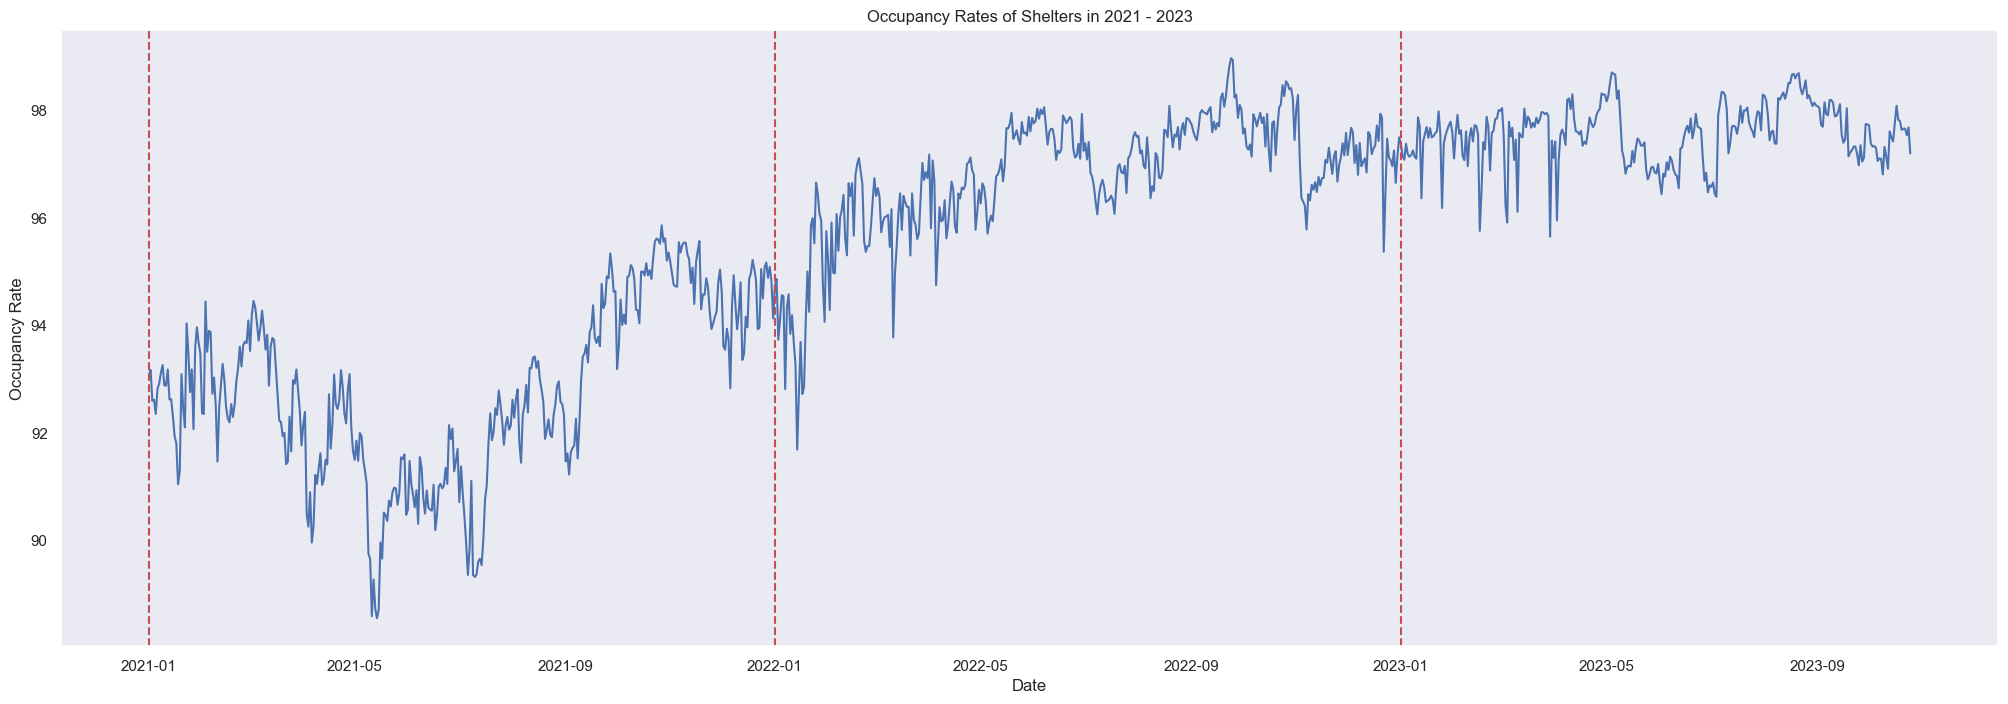

In [28]:
# BEDS plot
dates = pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d').unique()
toronto_occupany_averages_beds = toronto_shelter_usage[toronto_shelter_usage["OCCUPANCY_RATE_BEDS"] != 0].groupby(pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d'))["OCCUPANCY_RATE_BEDS"].mean()

plt.figure(figsize=(25, 8))
plt.plot(#pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d').unique(), 
         toronto_shelter_usage[toronto_shelter_usage["OCCUPANCY_RATE_BEDS"] != 0].groupby(pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d'))["OCCUPANCY_RATE_BEDS"].mean())
plt.title('Occupancy Rates of Shelters in 2021 - 2023')
plt.ylabel('Occupancy Rate')
plt.xlabel('Date')
year_change = ['2023-01-01', '2022-01-01', '2021-01-01']
for date in year_change:
    plt.axvline(pd.to_datetime(date), color='r', linestyle='--', label='Year Changes')
plt.grid(False)
plt.show()


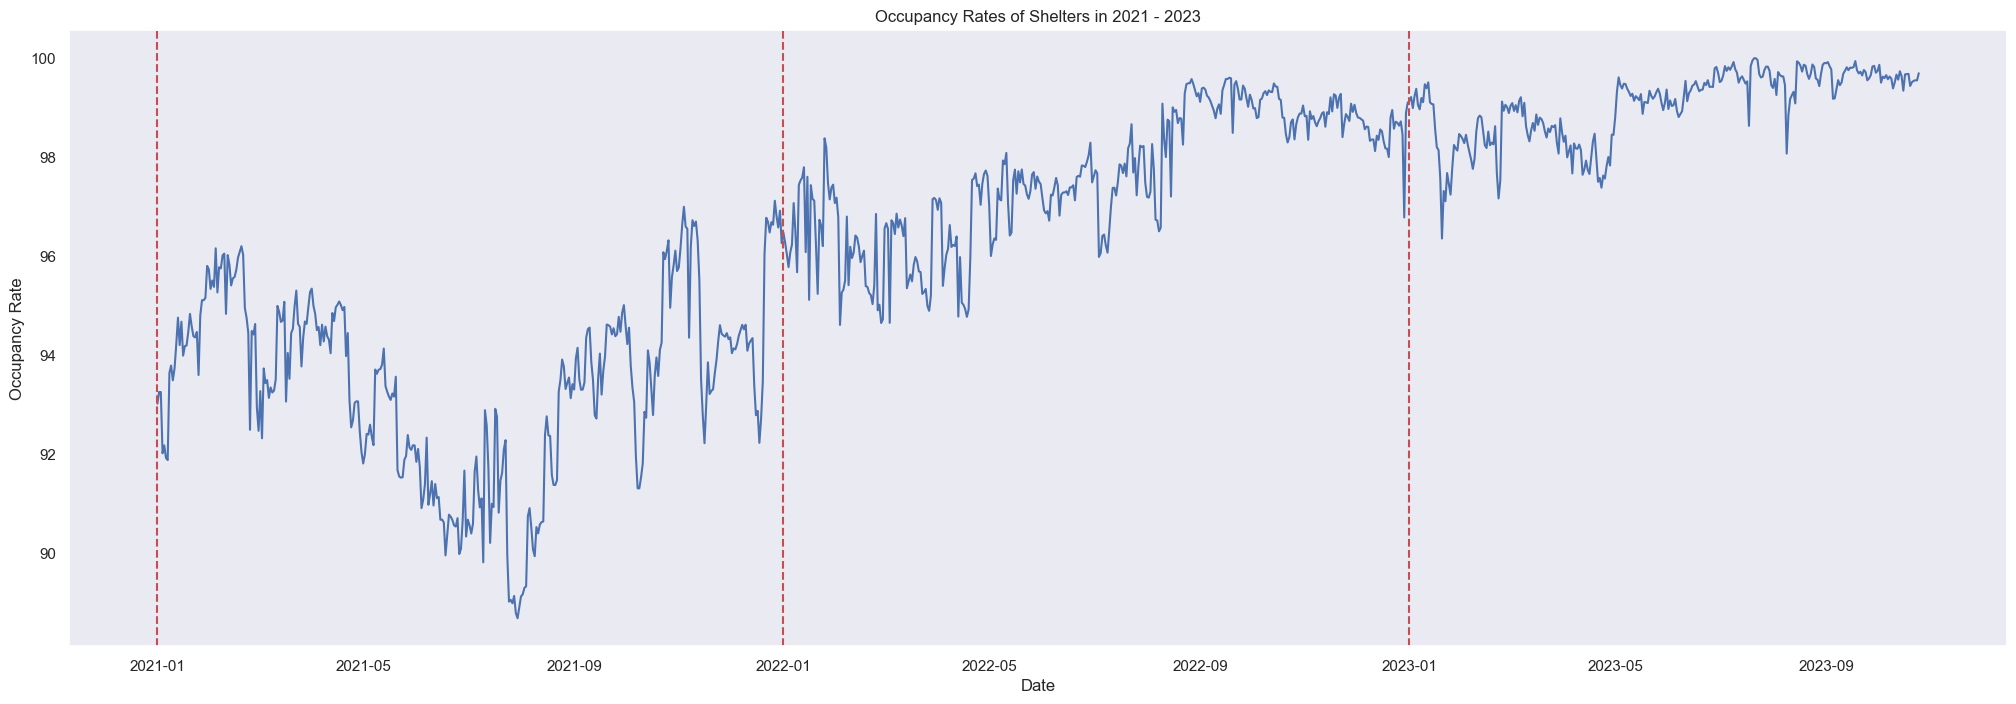

In [30]:
# ROOMS plot
dates = pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d').unique()
toronto_occupany_averages_rooms = toronto_shelter_usage[toronto_shelter_usage["OCCUPANCY_RATE_ROOMS"] != 0].groupby(pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d'))["OCCUPANCY_RATE_ROOMS"].mean()

plt.figure(figsize=(25, 8))
plt.plot(#pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d').unique(), 
         toronto_shelter_usage[toronto_shelter_usage["OCCUPANCY_RATE_ROOMS"] != 0].groupby(pd.to_datetime(toronto_shelter_usage["OCCUPANCY_DATE"], format='%Y-%m-%d'))["OCCUPANCY_RATE_ROOMS"].mean())
plt.title('Occupancy Rates of Shelters in 2021 - 2023')
plt.ylabel('Occupancy Rate')
plt.xlabel('Date')
year_change = ['2023-01-01', '2022-01-01', '2021-01-01']
for date in year_change:
    plt.axvline(pd.to_datetime(date), color='r', linestyle='--', label='Year Changes')

plt.grid(False)
plt.show()


TIME SERIES ANALYSIS

In [31]:
# MOVING AVERAGE
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], color = 'lightblue', label='Actual values')
    year_change = ['2023-01-01', '2022-01-01', '2021-01-01']
    for date in year_change:
        plt.axvline(pd.to_datetime(date), color='black', linestyle='--', label='Year Changes')
    plt.legend(loc='best')
    plt.grid(True)


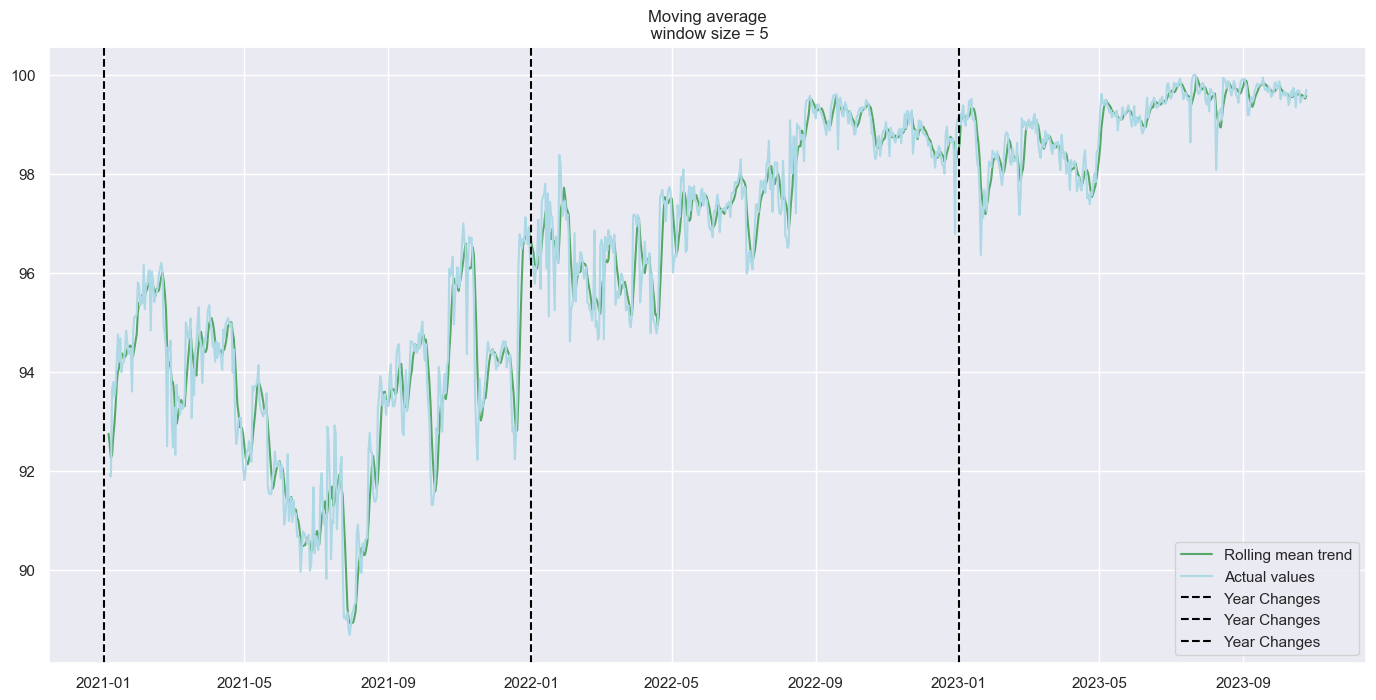

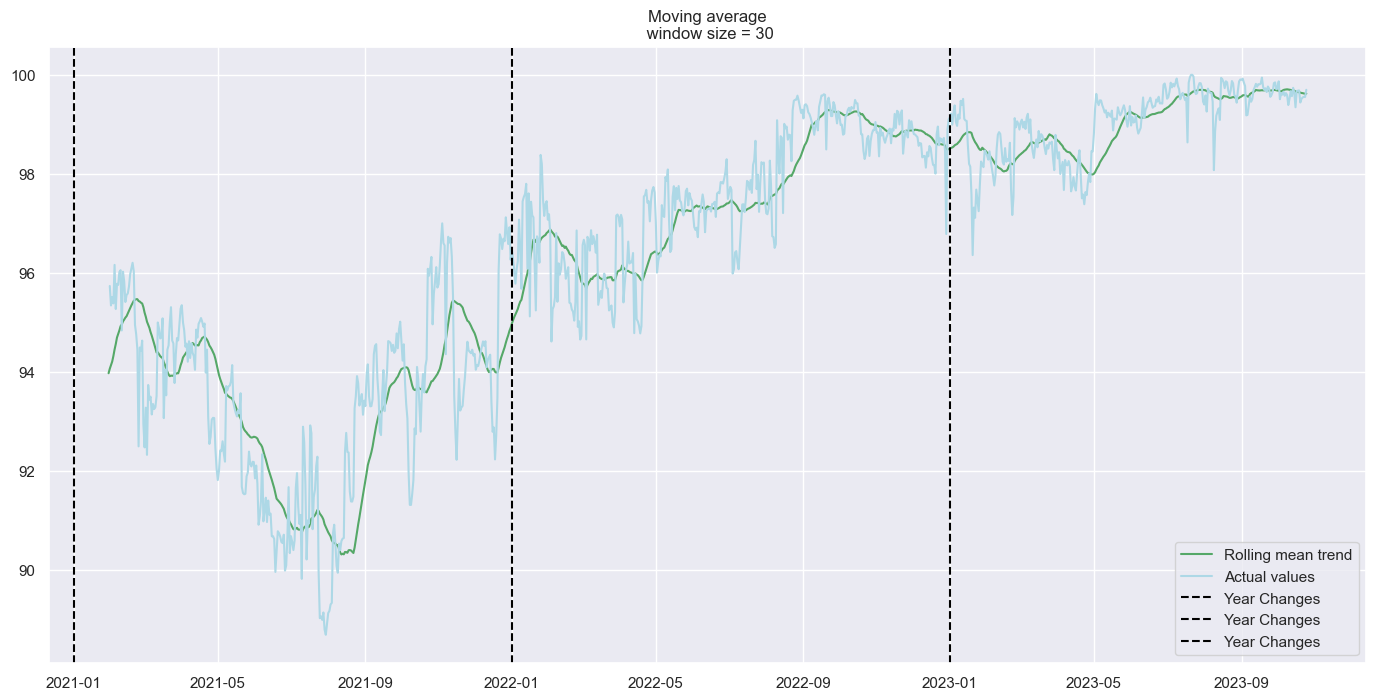

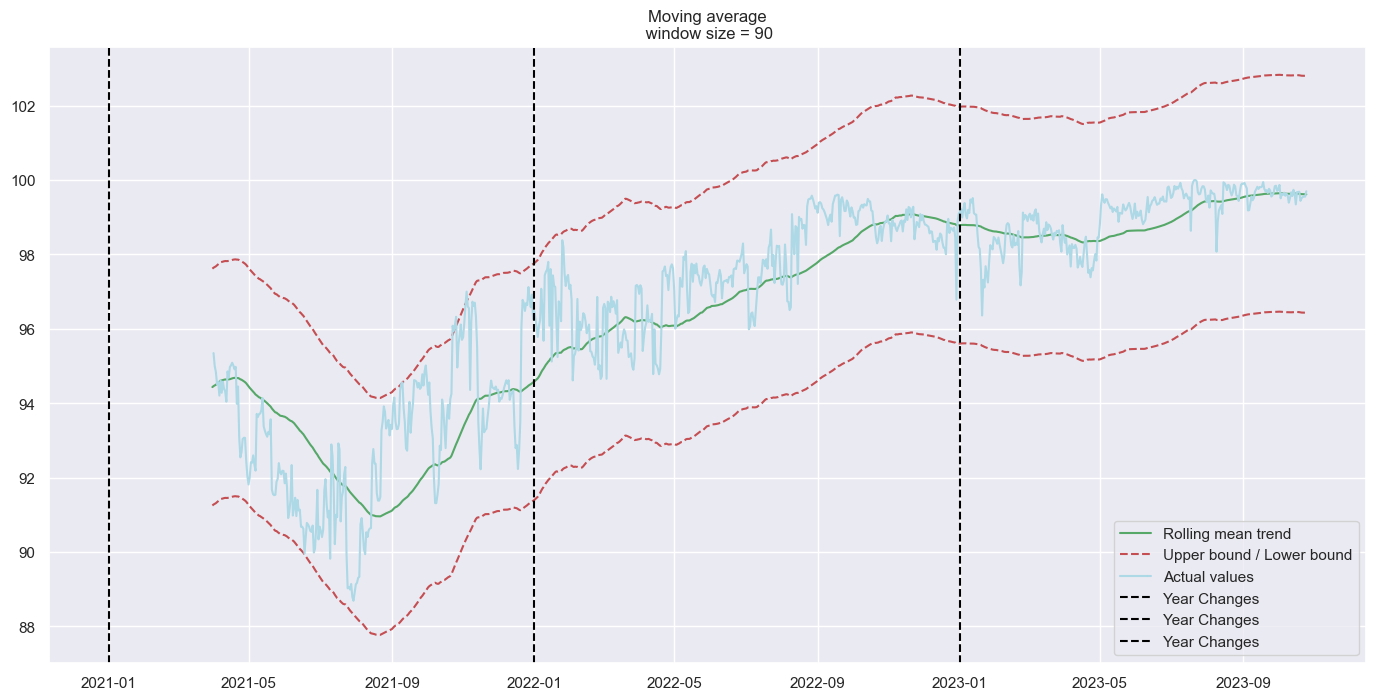

In [32]:
# rooms 
#Smooth by the previous 5 days (by week)
plot_moving_average(toronto_occupany_averages_rooms, 5)

#Smooth by the previous month (30 days)
plot_moving_average(toronto_occupany_averages_rooms, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(toronto_occupany_averages_rooms, 90, plot_intervals=True)

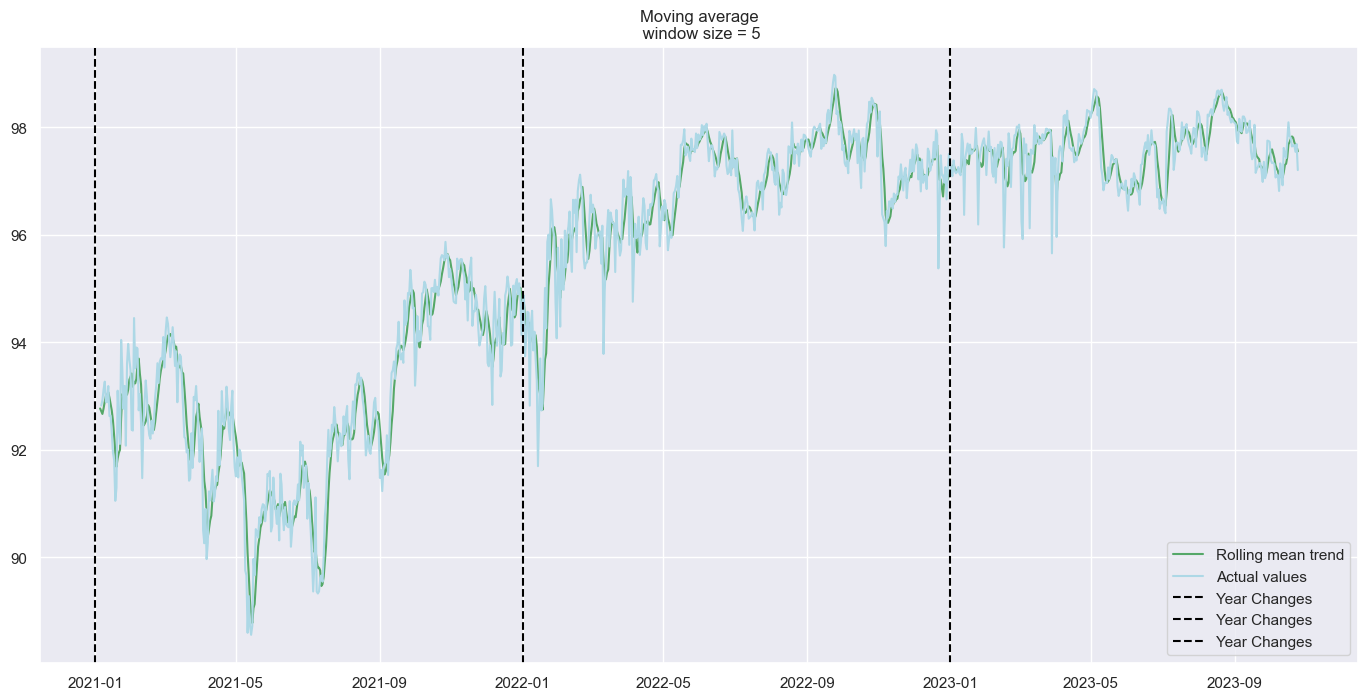

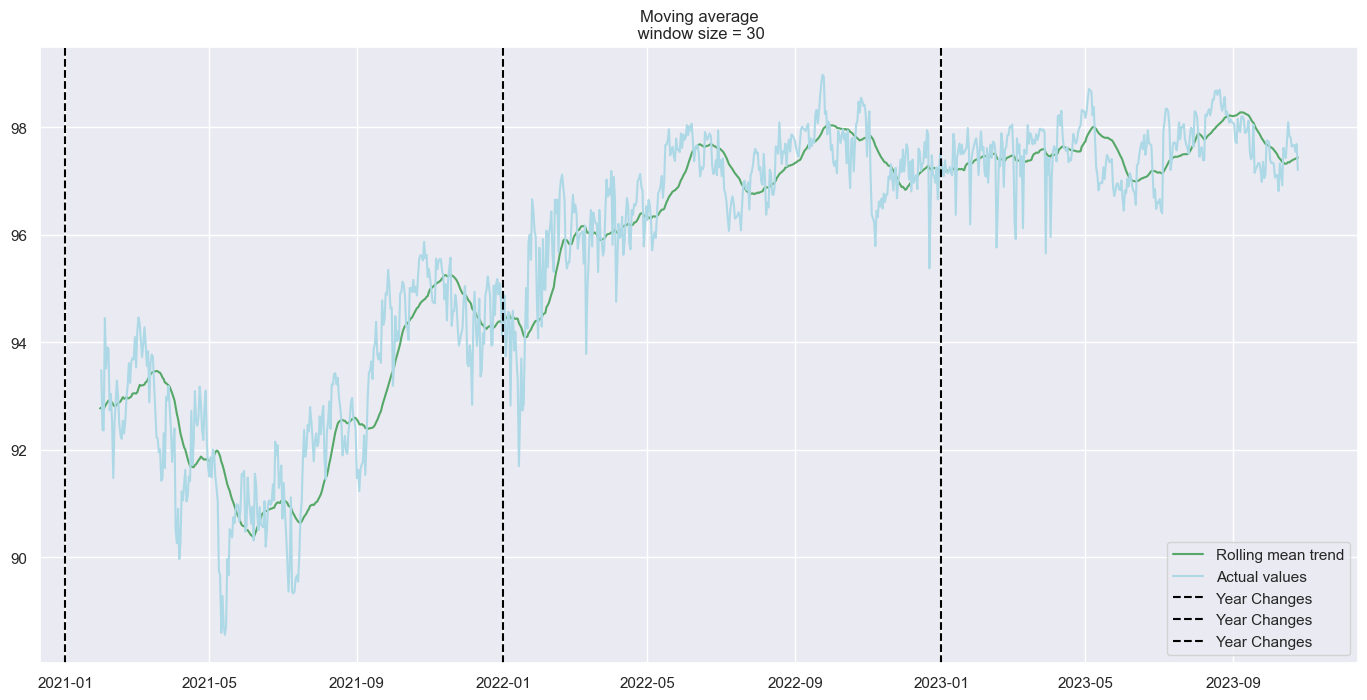

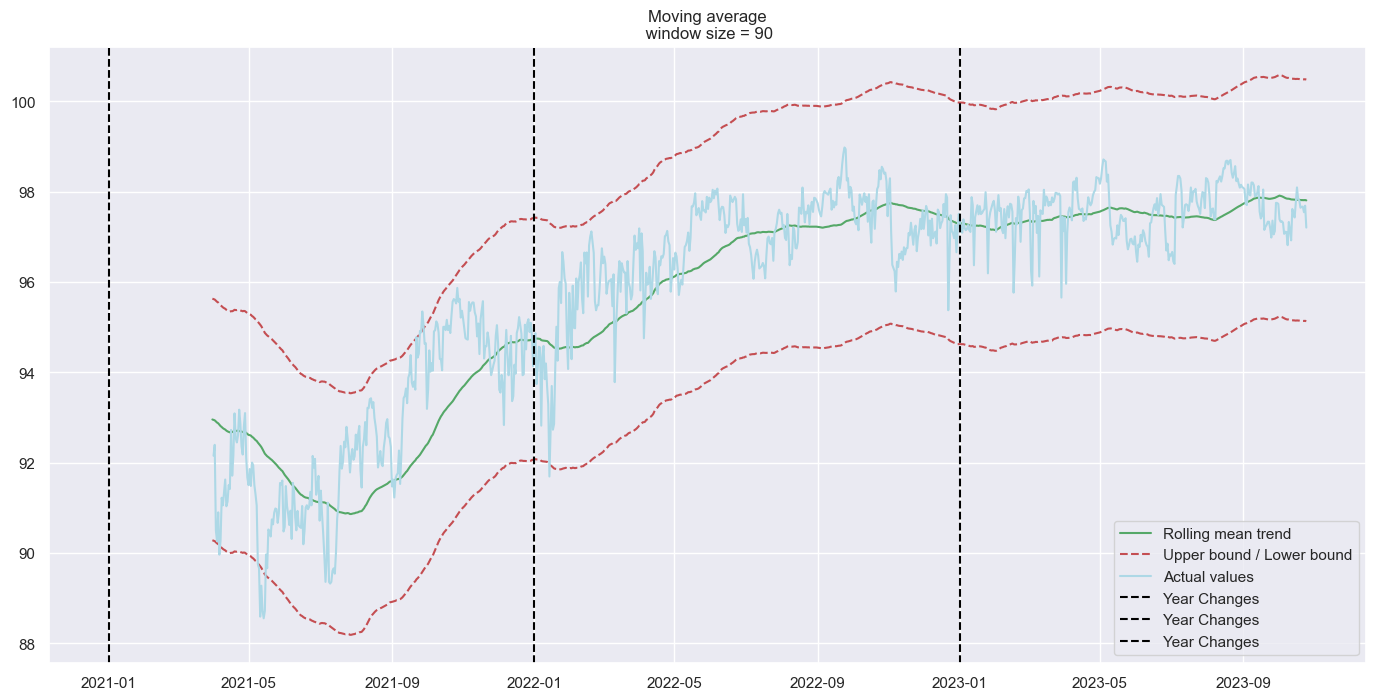

In [33]:
# beds
#Smooth by the previous 5 days (by week)
plot_moving_average(toronto_occupany_averages_beds, 5)

#Smooth by the previous month (30 days)
plot_moving_average(toronto_occupany_averages_beds, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(toronto_occupany_averages_beds, 90, plot_intervals=True)

In [34]:
# EXPONENTIAL SMOOTHING
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);




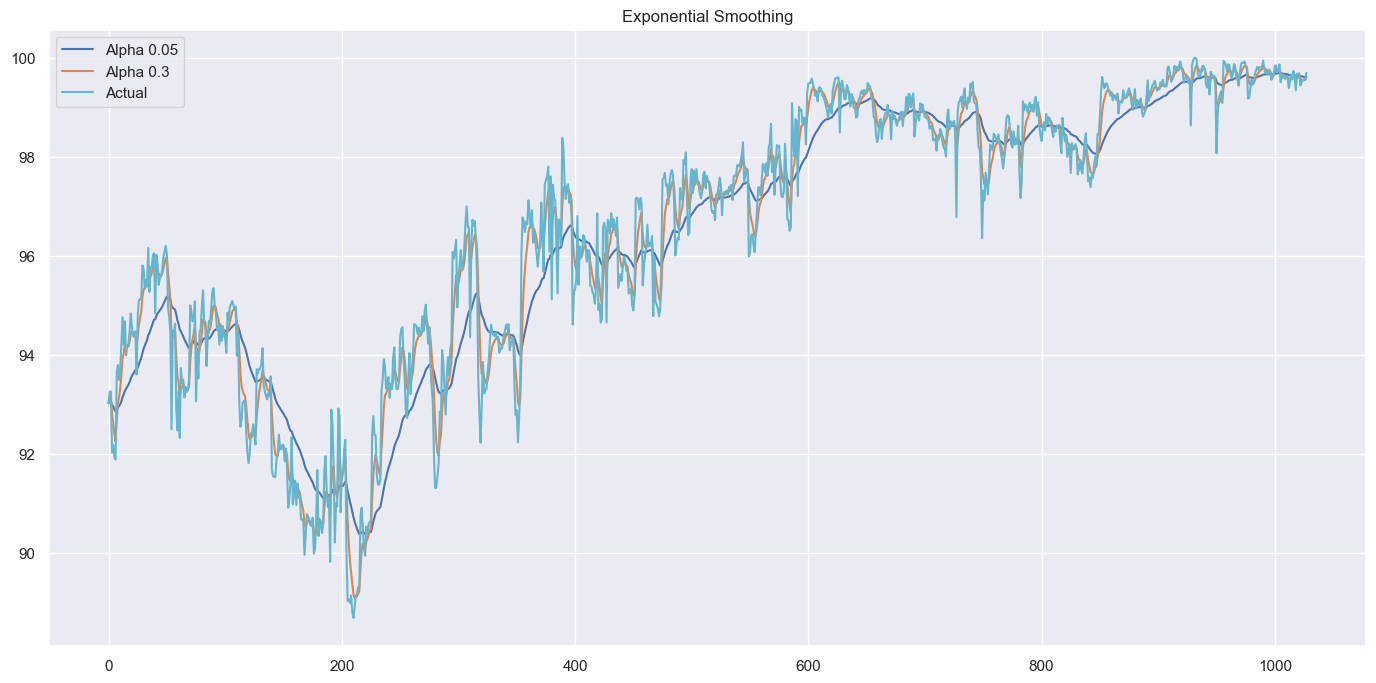

In [35]:
# rooms
plot_exponential_smoothing(toronto_occupany_averages_rooms, [0.05, 0.3])
# year_change = ['2023-01-01', '2022-01-01', '2021-01-01']
# for date in year_change:
#     exp.axvline(pd.to_datetime(date), color='black', linestyle='--', label='Year Changes')

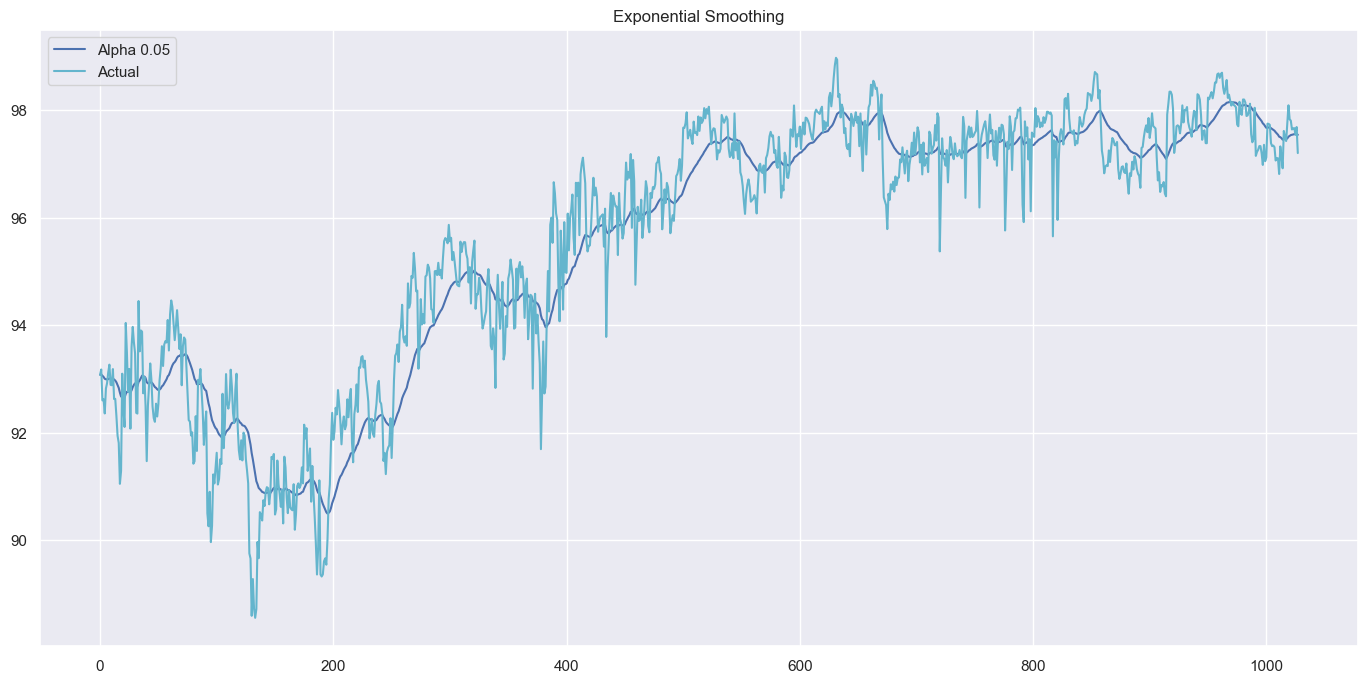

In [36]:
# beds
plot_exponential_smoothing(toronto_occupany_averages_beds, [0.05])

In [37]:
# double exponential smoothing

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    


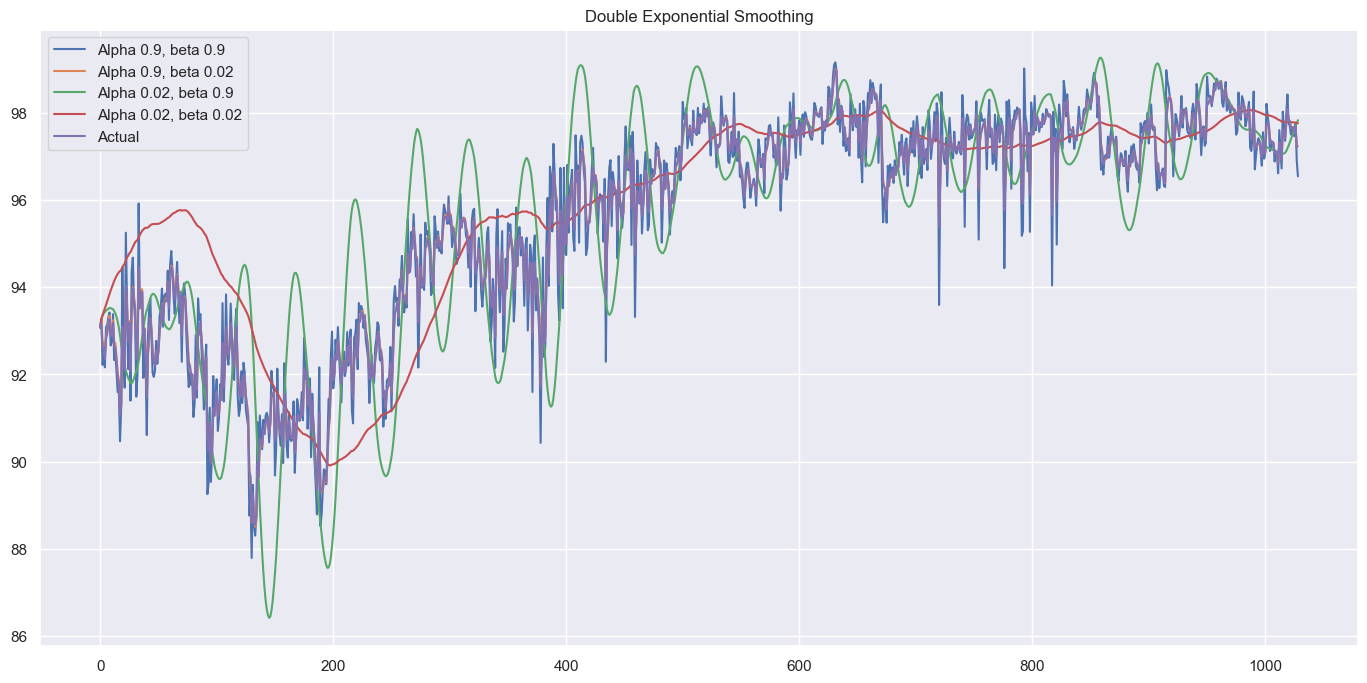

In [38]:
# beds 
plot_double_exponential_smoothing(toronto_occupany_averages_beds, alphas=[0.9, 0.02], betas=[0.9, 0.02])

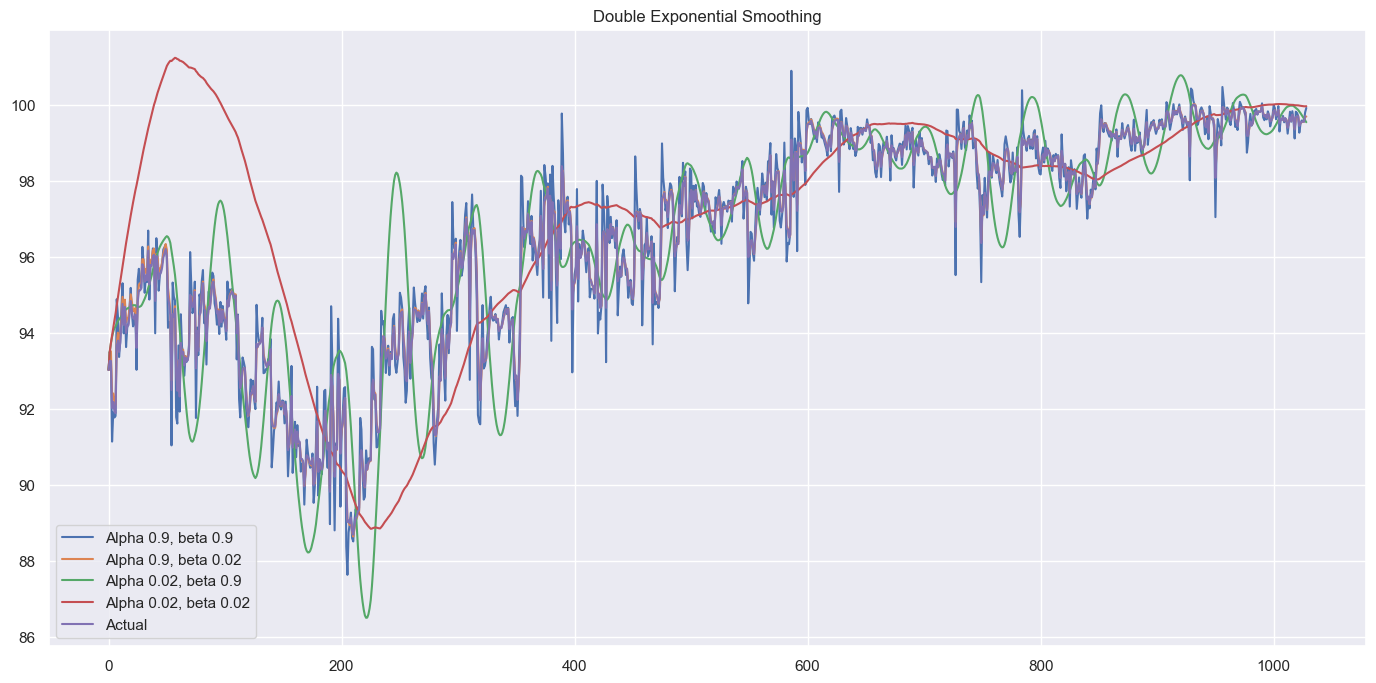

In [39]:
# rooms
plot_double_exponential_smoothing(toronto_occupany_averages_rooms, alphas=[0.9, 0.02], betas=[0.9, 0.02])

TESTING TO SEE IF THE TIME SERIES IS STATIONARY

In [40]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    

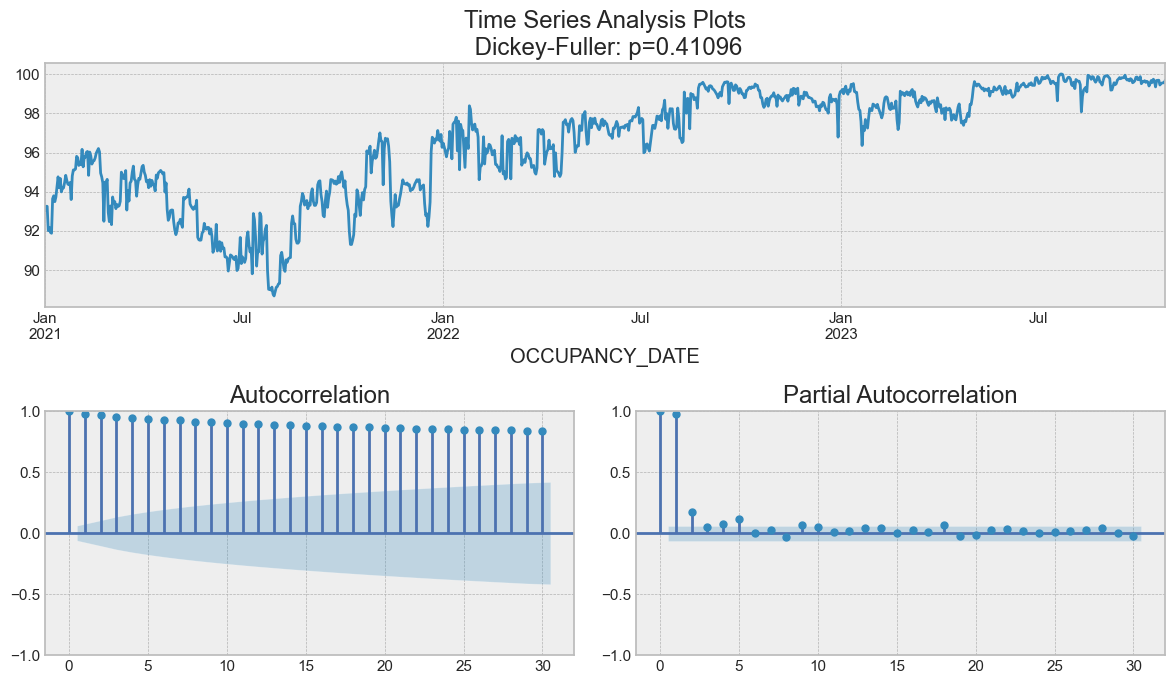

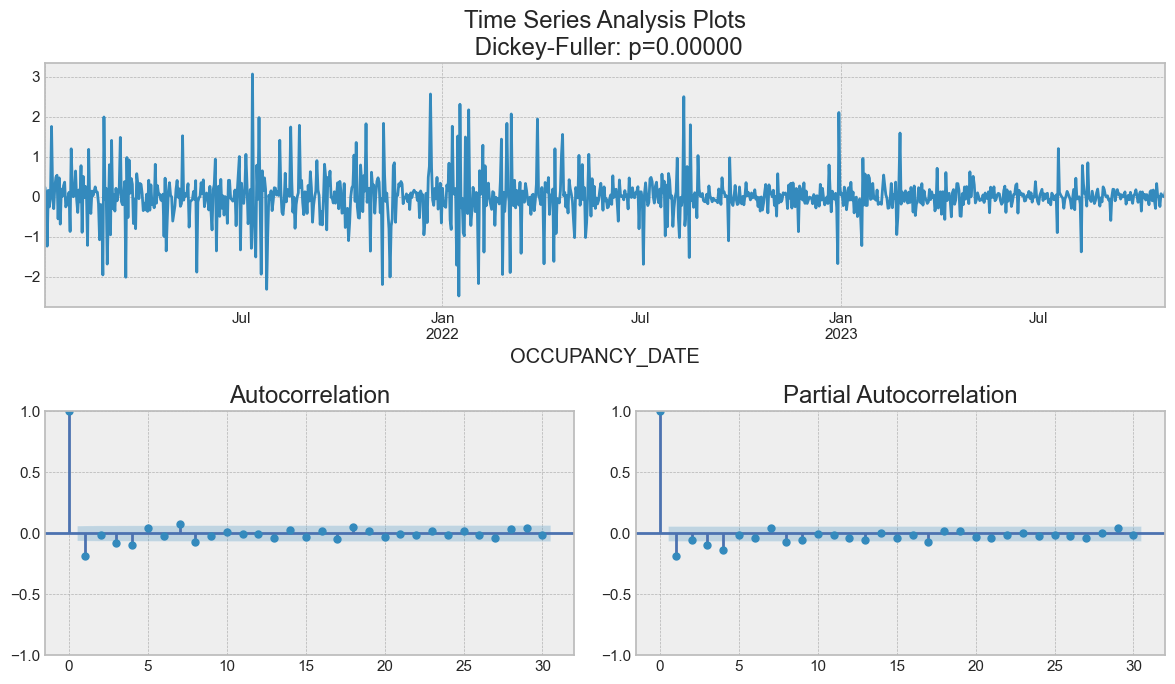

In [41]:
# rooms
tsplot(toronto_occupany_averages_rooms, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = toronto_occupany_averages_rooms - toronto_occupany_averages_rooms.shift(1)

tsplot(data_diff[1:], lags=30)

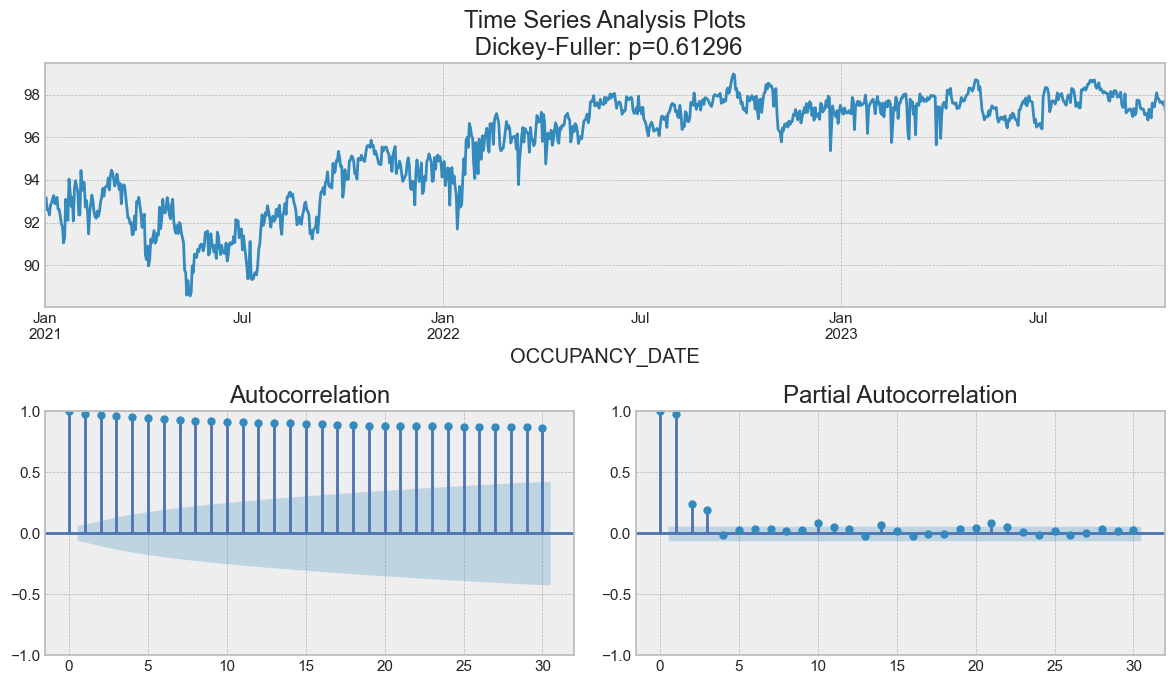

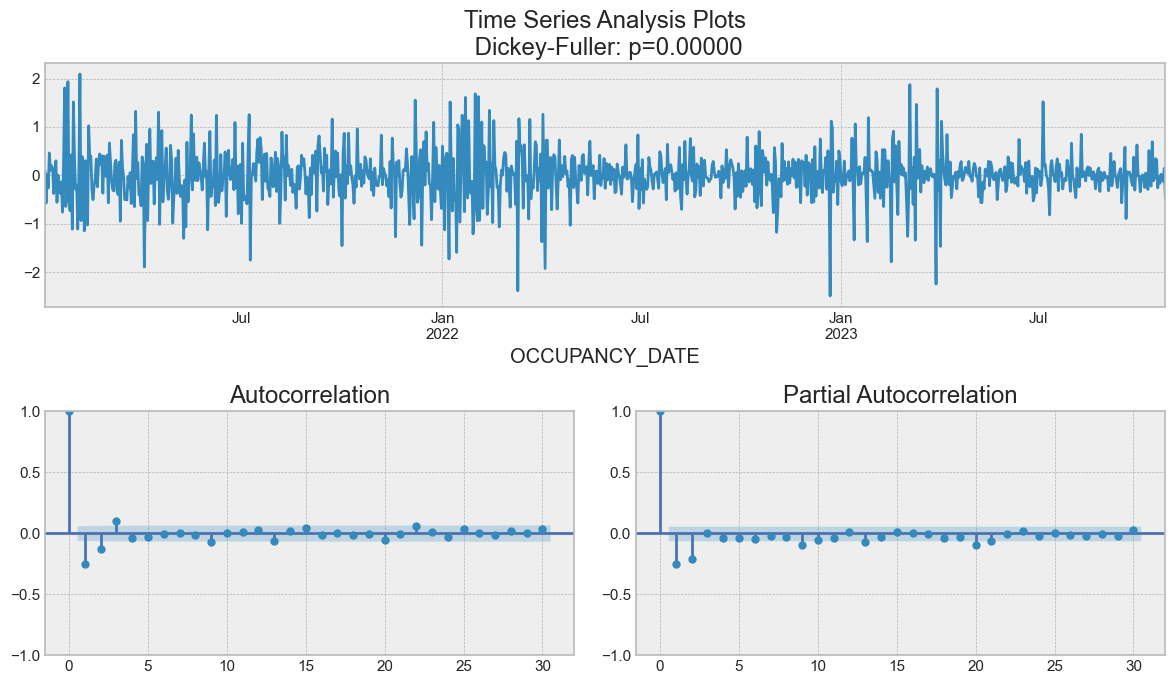

In [42]:
# beds
tsplot(toronto_occupany_averages_beds, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = toronto_occupany_averages_beds - toronto_occupany_averages_beds.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
# MODELLING WITH SARIMA

# TODO : work on this code to see how modelling with SARIMA is

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())